## Results of Host Prediction
### Dataset: Coronaviridae S prot, EMBL mapping, Vertebrates

**Models**: TF - Pretrain  + finetune

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1036

**Classification**: Multi-class

**\# classes**: 8

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 

In [1]:
import seaborn

In [2]:
seaborn.__version__

'0.11.2'

In [3]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['C:\\Dev\\git\\zoonosis\\src\\jupyter_notebooks\\results-analysis\\coronaviridae\\embl',
 'C:\\Users\\bless\\anaconda3\\python39.zip',
 'C:\\Users\\bless\\anaconda3\\DLLs',
 'C:\\Users\\bless\\anaconda3\\lib',
 'C:\\Users\\bless\\anaconda3',
 '',
 'C:\\Users\\bless\\anaconda3\\lib\\site-packages',
 'C:\\Users\\bless\\anaconda3\\lib\\site-packages\\locket-0.2.1-py3.9.egg',
 'C:\\Users\\bless\\anaconda3\\lib\\site-packages\\win32',
 'C:\\Users\\bless\\anaconda3\\lib\\site-packages\\win32\\lib',
 'C:\\Users\\bless\\anaconda3\\lib\\site-packages\\Pythonwin',
 'C:\\Users\\bless\\anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\bless\\.ipython',
 'C:\\Dev\\git\\zoonosis\\src\\jupyter_notebooks\\results-analysis\\coronaviridae\\embl\\..\\..\\..\\..\\..',
 'C:\\Dev\\git\\zoonosis\\src\\jupyter_notebooks\\results-analysis\\coronaviridae\\embl\\..\\..\\..\\..',
 'C:\\Dev\\git\\zoonosis\\src\\jupyter_notebooks\\results-analysis\\coronaviridae\\embl\\..\\..\\..',
 'C:\\Dev\\git\\

In [4]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

from src.utils import utils, evaluation_utils, visualization_utils

ModuleNotFoundError: No module named 'torch'

In [18]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.autolayout'] = True

DEFAULT_FIGURE_CONFIG = {
    "figsize": (10, 10),
    "xtick.labelsize": 18,
    "ytick.labelsize": 18    
}


def plot_auprc(auprc_df, metadata, model_name):
    # sort by median
    sorted_median_auprc_df = auprc_df.groupby("class")["auprc"].median().sort_values(ascending=False)
    visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
    plt.rcParams['xtick.labelsize'] = 18
    plt.rcParams['ytick.labelsize'] = 18
    ax = sns.boxplot(data=auprc_df, x="class", y="auprc", order=sorted_median_auprc_df.index)
    
    ax.set_ylim(0, 1)
    # ax.set_xticklabels([metadata[t.get_text()] for t in ax.get_xticklabels()])
    ax.set_title(f"Model = {model_name}")
    plt.tight_layout()
    plt.xticks(rotation=-90)
    plt.show()
        
def auprc_analysis(output_filepath, model_name):
    df = pd.read_csv(output_filepath, index_col=0)
    print(f"Read output size = {df.shape}")
    cols = df.columns
    non_human_cols = list(set(cols) - set([itr_col, experiment_col, y_true_col, human_col]))
    print(f"NonHuman cols = {non_human_cols}")
    itrs = df[itr_col].unique()
    
    auprc = []
    pr_curves = []
    for itr in itrs:
        df_itr = df[df[itr_col] == itr]
        pr_curves_df, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=non_human_cols + [human_col], y_true_col=y_true_col)
        pr_curves_df[itr_col] = itr
        auprcs_df[itr_col] = itr
        auprc.append(auprcs_df)
        pr_curves.append(pr_curves_df)

    auprc_df = pd.concat(auprc, ignore_index=True)
    pr_curves_df = pd.concat(pr_curves, ignore_index=True)
    
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    
    plot_auprc(auprc_df, metadata, model_name)
    visualization_utils.curve_plot(pr_curves_df, x_col="recall", y_col="precision",
                                   color_group_col="class", style_group_col=None,
                                   output_file_path=None, metadata=metadata)
    

def auprc_analysis_classes_subset(output_filepaths, classes):
    macro_auprcs = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            macro_auprcs.append({"model": model,
                                 "itr": itr,
                                 "auprc": auprcs_df["auprc"].mean()})
    macro_auprcs_df = pd.DataFrame(macro_auprcs)

    visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
    ax = sns.boxplot(data=macro_auprcs_df, x="model", y="auprc")
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=20)
    ax.set_title(f"Macro AUPRC [Classes = {classes}]")
    visualization_utils.wrap_xticklabels(ax)
    visualization_utils.view(figure_output_filepath)
    plt.show()
    

In [19]:
def class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath):
    auprc_results = []
    for model, output_filepath in output_filepaths.items():
        df = pd.read_csv(output_filepath, index_col=0)
        print(f"Read output {model} = {df.shape}")
        
        cols = df.columns
        classes = list(set(cols) - set([itr_col, experiment_col, y_true_col]))
        itrs = df[itr_col].unique()
    
        for itr in itrs:
            df_itr = df[df[itr_col] == itr]
            _, auprcs_df = evaluation_utils.compute_class_auprc(df_itr, y_pred_columns=classes, y_true_col=y_true_col)
            auprcs_df["model"] = model
            auprcs_df["itr"] = itr
            auprc_results.append(auprcs_df)
    metadata = utils.compute_class_distribution(df_itr, y_true_col, format=False)
    metadata_formatted = utils.compute_class_distribution(df_itr, y_true_col, format=True)
    metadata_sorted = {}
    for k, v in metadata.items():
        metadata_sorted[metadata_formatted[k]] = v

    auprc_results_df = pd.concat(auprc_results, ignore_index=True)
    auprc_results_df.replace({"class":metadata_formatted}, inplace=True)
    
    FIGURE_CONFIG = {
        "figsize": (10, 8),
        "xtick.labelsize": 16,
        "ytick.labelsize": 16    
    }

    visualization_utils.pre_plot_config(FIGURE_CONFIG)
    ax = sns.boxplot(data=auprc_results_df, x="class", y="auprc", hue="model", order=metadata_sorted)
    plt.draw()
    
    ax.set_ylim(0, 1)
    ax.set_ylabel("AUPRC", size=18)
    ax.set_xlabel("Classes", size=18, labelpad=2)
    sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=5, title=None, frameon=False)
    plt.setp(ax.get_legend().get_texts(), fontsize=16)
    visualization_utils.wrap_xticklabels(ax)
    visualization_utils.view(figure_output_filepath)
    plt.show()
    return auprc_results_df

### FNN

In [ ]:
fnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240229/host_multi/emb_sincos-lossfocalce_e50_msl1036_fnn-l_10-d_1024-lr1e-3_output.csv")
#auprc_analysis(fnn_output_filepath, "FNN")

### RNN

In [ ]:
#rnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240229/host_multi/emb_sincos-lossfocalce_e50_msl1036_rnn-l_6-d_1024-lr1e-5_output.csv")
#auprc_analysis(rnn_output_filepath, "RNN")

### CNN

In [8]:
cnn_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240229/host_multi/emb_sincos-lossfocalce_e50_msl1036_cnn-l_4-d_1024-k3s1-lr1e-3_output.csv")
#auprc_analysis(cnn_output_filepath, "CNN")

### LSTM

In [3]:
lstm_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240229/host_multi/emb_sincos-lossfocalce_e50_msl1036_lstm-l_2-d_1024-lr1e-3_output.csv")
#auprc_analysis(lstm_output_filepath, "LSTM")

### Transformer-Encoder

In [4]:
tf_enc_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240228/host_multi/emb_sincos-d1024-lossfocalce_e50_msl1036_transformer-l_6-h_8-lr1e-4_output.csv")
#auprc_analysis(tf_output_filepath, "Transformer")

### ProteinBERT

In [5]:
proteinbert_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240306/protein_bert/prediction_results_20240308_022609_mapped.csv")
#auprc_analysis(ft_tf_output_filepath, "Transformer: Pre-training + Fine-tuning")

### VirProBERT

In [6]:
virprobert_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/raw/uniref90_embl_vertebrates_non_idv_t0.01_c5/20240307/host_multi/fine_tuning/mlm_tfenc_l6_h8_lr1e-4_uniref90viridae_msl1366_host_prediction_fnn_2l_d1024_lr1e-4_fe20_ufe30_output.csv")
#auprc_analysis(ft_tf_output_filepath, "Transformer: Pre-training + Fine-tuning")

### Classwise AUPRC of all models

In [9]:
output_filepaths = {
    # "FNN_10l": fnn_output_filepath,
    # "RNN_6l": rnn_output_filepath,
    "CNN": cnn_output_filepath,
    "LSTM": lstm_output_filepath,
    "Transformer-Encoder": tf_enc_output_filepath,
    "ProteinBERT": proteinbert_output_filepath,
    "VirProBERT": virprobert_output_filepath
}
classes = ["Human", "Capybara", "Himalayan marmot", "Pig", "Red junglefowl"]
#auprc_analysis_classes_subset(output_filepaths, classes)

Read output CNN = (15860, 7)
Read output LSTM = (15860, 7)
Read output Transformer-Encoder = (15860, 7)
Read output ProteinBERT = (15860, 8)


/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/blessyantony/.local/lib/python3.8/site-packages/sklearn/metrics/_ranking.py:980: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


Read output VirProBERT = (15860, 7)


/home/blessyantony/dev/git/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/embl/../../../../../src/utils/visualization_utils.py:104: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(wrapped_labels, rotation=0)


<Figure size 432x288 with 0 Axes>

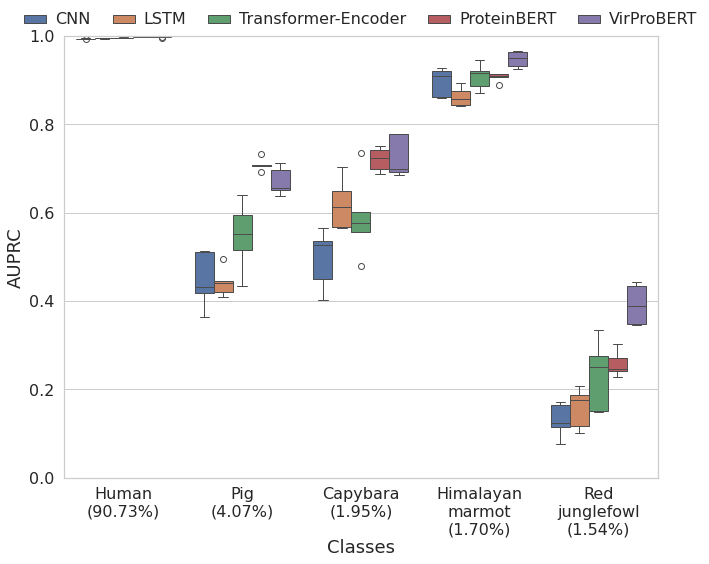

In [20]:
figure_output_filepath = os.path.join(os.getcwd(), "..","..", "..", "..", "..", "output/visualization/uniref90/20240312/prelim_exam/host_multi_all_models_classwise_aurpc_boxplot.pdf")
auprc_results_df = class_wise_auprc_analysis(output_filepaths, classes, figure_output_filepath)

In [22]:
virprobert_auprc_results_df = auprc_results_df[auprc_results_df["model"] == "VirProBERT"]

In [23]:
virprobert_auprc_results_df

,class,auprc,model,itr
105,Pig (4.07%),0.696788,VirProBERT,0
106,Human (90.73%),0.996848,VirProBERT,0
107,Capybara (1.95%),0.698943,VirProBERT,0
108,Himalayan marmot (1.70%),0.963776,VirProBERT,0
109,Red junglefowl (1.54%),0.443607,VirProBERT,0
110,Pig (4.07%),0.711858,VirProBERT,1
111,Human (90.73%),0.997478,VirProBERT,1
112,Capybara (1.95%),0.778164,VirProBERT,1
113,Himalayan marmot (1.70%),0.931951,VirProBERT,1
114,Red junglefowl (1.54%),0.345904,VirProBERT,1


In [24]:
virprobert_auprc_results_df[["class", "auprc"]].groupby("class").mean("auprc")

,auprc
class,
Capybara (1.95%),0.726227
Himalayan marmot (1.70%),0.947746
Human (90.73%),0.996985
Pig (4.07%),0.671135
Red junglefowl (1.54%),0.391968
